In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, log_loss
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier, StackingRegressor, StackingClassifier
from xgboost.sklearn import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.kernel_approximation import Nystroem
from joblib import dump, load
from matplotlib import pyplot

In [2]:
# Import data
raw_train_df = pd.read_csv("train.csv")
raw_train_label_df = pd.read_csv('train_label.csv')
test_df = pd.read_csv("test.csv")

In [3]:
# Split into validation set and training set
dates = raw_train_df.arrival_date.unique()
train_indices, val_indices = train_test_split(dates, test_size=0.3, random_state=216)
train_df = raw_train_df.set_index('arrival_date').loc[train_indices, :]
val_df = raw_train_df.set_index('arrival_date').loc[val_indices, :]

In [4]:
train_df.reset_index(drop=False, inplace=True)
val_df.reset_index(drop=False, inplace=True)

In [5]:
# ColumnTransformer

# Transforming the categoric columns
cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)

# Transforming the numeric columns
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step, num_ss_step]
num_pipe = Pipeline(num_steps)

In [6]:
# Stage 1: Predict ADR by regression
# Determine features
adr_numericCols = ['lead_time', 'arrival_date_year', 'stays', 'stays_in_weekend_nights', 'stays_in_week_nights',\
               'adults', 'children', 'babies', 'persons', 'previous_cancellations',\
               'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',\
               'required_car_parking_spaces', 'total_of_special_requests'
              ]
adr_categoricCols = ['hotel', 'arrival_date_month',\
                'arrival_date_week_number', 'arrival_date_day_of_month', 'meal',\
                'country', 'market_segment', 'distribution_channel',\
                'is_repeated_guest', 'reserved_room_type', 'assigned_room_type',\
                'deposit_type', 'customer_type', 'agent', 'company'
               ]

adr_featureCols = adr_numericCols + adr_categoricCols

In [7]:
adr_train = train_df[adr_featureCols]
adr_val = val_df[adr_featureCols]

In [8]:
# Combining both categorical and numerical column transformations
adr_ct = ColumnTransformer(transformers=[('cat', cat_pipe, adr_categoricCols), ('num', num_pipe, adr_numericCols)])
adr_train_transformed = adr_ct.fit_transform(adr_train)

In [9]:
# Retrieving the feature names
cat_transformers = [('cat', cat_pipe, adr_categoricCols)]
cat_ct = ColumnTransformer(transformers=cat_transformers)
train_cat_transformed = cat_ct.fit_transform(train_df)

num_transformers = [('num', num_pipe, adr_numericCols)]
num_ct = ColumnTransformer(transformers=num_transformers)
train_num_transformed = num_ct.fit_transform(train_df)

cat_pl = cat_ct.named_transformers_['cat']
ohe = cat_pl.named_steps['ohe']
transformed_feature_names = list(ohe.get_feature_names()) + adr_numericCols
print("Total number of features = ", len(transformed_feature_names))

Total number of features =  857


In [10]:
# feature selection
adr_sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
adr_svd = TruncatedSVD(n_components=40) # best 35

In [71]:
# Linear regression
ridge = Ridge(alpha=1.0/(2*100), max_iter=10000) # alpha = 1 / 2C
ridge_pipe = Pipeline([('adr_transform', adr_ct), ('ridge', ridge)], verbose=100)

In [136]:
# Execute ridge pipeline
ridge_pipe.fit(adr_train, train_df['adr'])

# Correlation coefficients
print(ridge_pipe.score(adr_train, train_df['adr']))
print(ridge_pipe.score(adr_val, val_df['adr']))

# Mean squared errors
print(mean_squared_error(ridge_pipe.predict(adr_train), train_df['adr']))
print(mean_squared_error(ridge_pipe.predict(adr_val), val_df['adr']))

0.5396044840978833
0.6039522121224565
1224.477257650087
794.8081163227173


In [40]:
# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1126)

# Selecting parameters when Grid Searching
param_grid = {
    'ridge__alpha': [1.0/(2*50), 1.0/(2*75), 1.0/(2*100), 1.0/(2*125), 1.0/(2*150)]
}

raw_adr_train = raw_train_df[adr_featureCols]
gs = GridSearchCV(ridge_pipe, param_grid, cv=kf, verbose=100, n_jobs=1)
gs.fit(raw_adr_train, raw_train_df['adr'])

print(gs.best_params_)
print(gs.best_score_)

# Getting all the grid search results in a Pandas DataFrame
print(pd.DataFrame(gs.cv_results_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] ridge__alpha=0.01 ...............................................
[CV] ................... ridge__alpha=0.01, score=0.654, total=   1.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[CV] ridge__alpha=0.01 ...............................................
[CV] ................... ridge__alpha=0.01, score=0.381, total=   1.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[CV] ridge__alpha=0.01 ...............................................
[CV] ................... ridge__alpha=0.01, score=0.665, total=   1.7s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s
[CV] ridge__alpha=0.01 ...............................................
[CV] ................... ridge__alpha=0.01, score=0.664, total=   1.7s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

In [26]:
# SVR
rbf_feature = Nystroem(gamma=10**(-1.5), n_components=600, random_state=1126)
sgdreg = SGDRegressor(loss='epsilon_insensitive', alpha=10**(-11), max_iter=10000)

sgd_pipe = Pipeline([('adr_transform', adr_ct), ('rbf', rbf_feature), ('sgdreg', sgdreg)])

In [28]:
# Execute svr pipeline
sgd_pipe.fit(adr_train, train_df['adr'])

# Correlation coefficients
print(sgd_pipe.score(adr_train, train_df['adr']))
print(sgd_pipe.score(adr_val, val_df['adr']))

# Mean squared errors
print(mean_squared_error(sgd_pipe.predict(adr_train), train_df['adr']))
print(mean_squared_error(sgd_pipe.predict(adr_val), val_df['adr']))

0.38272605380374847
0.45698674243912296
1591.1612936139725
1179.9846833209801


In [224]:
# Gradient boosting regressor
gbreg = GradientBoostingRegressor(loss='huber',
                                  alpha=0.9,
                                  learning_rate=0.1,
                                  validation_fraction=0.2,
                                  n_iter_no_change=5,
                                  tol=0.005,
                                  max_depth=6,
                                  subsample=0.8,
                                  n_estimators=10000,
                                  random_state=1126,
                                  verbose=True)
gbreg_pipe = Pipeline([('adr_transform', adr_ct), ('gbreg', gbreg)], verbose=100)

In [223]:
# Execute gradient boosting pipeline
gbreg_pipe.fit(adr_train, train_df['adr'])

# Correlation coefficients
print(gbreg_pipe.score(adr_train, train_df['adr']))
print(gbreg_pipe.score(adr_val, val_df['adr']))

# Mean squared errors
print(mean_squared_error(gbreg_pipe.predict(adr_train), train_df['adr']))
print(mean_squared_error(gbreg_pipe.predict(adr_val), val_df['adr']))

[Pipeline] ..... (step 1 of 2) Processing adr_transform, total=   0.7s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         791.0031          71.2462           89.58m
         2         710.3068          79.9412           85.63m
         3         640.6585          67.5975           83.62m
         4         582.5683          55.5360           82.94m
         5         537.3059          46.3521           83.74m
         6         498.8246          37.9991           83.69m
         7         459.6104          32.2106           83.31m
         8         429.8022          30.7081           83.80m
         9         408.0195          24.1427           83.32m
        10         386.4751          20.0305           83.78m
        20         257.6708           7.2525           83.78m
        30         200.1122           5.4780           83.26m
        40         172.5247           2.4070           77.94m
        50         157.1923           1.3468           74.77

In [45]:
# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1126)

# Selecting parameters when Grid Searching
param_grid = {
    'gbreg__learning_rate': [0.1],
    'gbreg__subsample': [0.8]
}

raw_adr_train = raw_train_df[adr_featureCols]
gs = GridSearchCV(gbreg_pipe, param_grid, cv=kf, verbose=100, n_jobs=1)
gs.fit(raw_adr_train, raw_train_df['adr'])

print(gs.best_params_)
print(gs.best_score_)

# Getting all the grid search results in a Pandas DataFrame
print(pd.DataFrame(gs.cv_results_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] gbreg__learning_rate=0.1, gbreg__subsample=0.8 ..................
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         942.3188          59.9080           43.32m
         2         877.3441          57.1465           41.59m
         3         834.1607          47.5389           41.10m
         4         789.4696          40.9935           41.09m
         5         743.2766          49.8062           41.21m
         6         707.4602          38.3583           40.98m
         7         665.1406          36.4716           41.23m
         8         633.7590          36.0146           41.00m
         9         605.1403          25.8282           41.02m
        10         580.1455          26.9657           41.60m
        20         433.2342           8.7163           41.54m
        30         367.3260           4.1714

In [73]:
# XGBoost regressor
xgbreg = XGBRegressor(booster='gbtree',
                      objective='reg:pseudohubererror',
                      learning_rate=0.04,
                      n_estimators=10000,
                      subsample=0.8,
                      colsample_bytree=0.6, # best
                      max_depth=6,
                      gamma=5,
                      #reg_lambda=30.0,
                      random_state=1126)
xgbreg_pipe = Pipeline([('adr_transform', adr_ct), ('xgbreg', xgbreg)], verbose=100)

In [42]:
# Execute XGBoost pipeline
xgbreg_pipe.fit(adr_train, train_df['adr'])

# Correlation coefficients
print(xgbreg_pipe.score(adr_train, train_df['adr']))
print(xgbreg_pipe.score(adr_val, val_df['adr']))

# Mean squared errors
print(mean_squared_error(xgbreg_pipe.predict(adr_train), train_df['adr']))
print(mean_squared_error(xgbreg_pipe.predict(adr_val), val_df['adr']))

0.8360627481665961
0.705959108168488
426.57656959993005
619.4644781131004


In [47]:
# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1126)

# Selecting parameters when Grid Searching
param_grid = {
    'xgbreg__learning_rate': [0.01, 0.04],
    'xgbreg__subsample': [0.6, 0.8]
}

raw_adr_train = raw_train_df[adr_featureCols]
gs = GridSearchCV(xgbreg_pipe, param_grid, cv=kf, verbose=100, n_jobs=1)
gs.fit(raw_adr_train, raw_train_df['adr'])

print(gs.best_params_)
print(gs.best_score_)

# Getting all the grid search results in a Pandas DataFrame
print(pd.DataFrame(gs.cv_results_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] xgbreg__learning_rate=0.01, xgbreg__subsample=0.6 ...............
[CV]  xgbreg__learning_rate=0.01, xgbreg__subsample=0.6, score=0.858, total= 3.0min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s
[CV] xgbreg__learning_rate=0.01, xgbreg__subsample=0.6 ...............
[CV]  xgbreg__learning_rate=0.01, xgbreg__subsample=0.6, score=0.498, total= 3.0min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.0min remaining:    0.0s
[CV] xgbreg__learning_rate=0.01, xgbreg__subsample=0.6 ...............
[CV]  xgbreg__learning_rate=0.01, xgbreg__subsample=0.6, score=0.867, total= 3.0min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.0min remaining:    0.0s
[CV] xgbreg__learning_rate=0.01, xgbreg__subsample=0.6 ...............
[CV]  xgbreg__learning_rate=0.01, xgbreg__subsample=0.6, score=0.860, total= 3.0min

In [16]:
print(xgbreg.feature_importances_)

[1.49277672e-02 9.48060583e-03 1.77365742e-04 3.03066336e-02
 2.31166696e-03 4.66068229e-03 4.99157654e-03 2.07430180e-02
 5.98067651e-03 3.26931179e-02 3.41507723e-03 3.04109184e-03
 2.53399927e-03 8.70812312e-03 5.38866036e-04 2.12808518e-04
 2.75918952e-04 1.14784183e-04 3.42918502e-04 3.64371925e-04
 3.11867916e-04 1.48078252e-04 4.95678571e-04 4.09991451e-04
 4.10673121e-04 2.97940656e-04 5.09187989e-02 2.49428645e-04
 1.26498835e-02 2.54907878e-04 8.68205243e-05 7.80449947e-04
 4.36787610e-04 3.39835795e-04 3.38189449e-04 2.18848675e-03
 3.98098229e-04 7.05795246e-04 1.65221898e-03 3.64407024e-04
 1.24695012e-03 1.77179917e-03 3.07910284e-03 5.02198795e-03
 5.55258384e-03 5.38135972e-03 1.58032924e-02 9.43005737e-03
 4.60958667e-03 1.44193089e-03 1.91030733e-03 7.49319501e-04
 7.96393212e-03 1.32569799e-03 1.39154051e-03 7.52143445e-04
 6.13126147e-04 1.10531051e-03 6.12902280e-04 2.28994503e-03
 9.31993884e-04 1.74645940e-03 1.47510681e-03 3.53727693e-04
 9.96627379e-04 6.237001

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

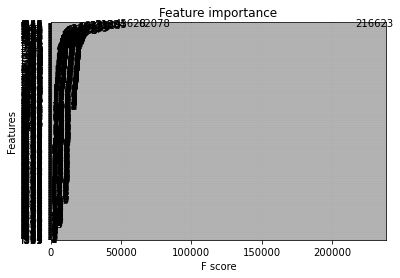

In [35]:
plot_importance(xgbreg)

In [89]:
# Stacking
gbr1 = GradientBoostingRegressor(loss='huber',
                                alpha=0.9,
                                validation_fraction=0.2,
                                n_iter_no_change=5,
                                tol=0.001,
                                max_depth=4,
                                n_estimators=10000,
                                random_state=0,
                                verbose=True)
gbr2 = GradientBoostingRegressor(loss='huber',
                                alpha=0.9,
                                validation_fraction=0.2,
                                n_iter_no_change=5,
                                tol=0.001,
                                max_depth=4,
                                n_estimators=10000,
                                random_state=100,
                                verbose=True)
gbr3 = GradientBoostingRegressor(loss='huber',
                                alpha=0.9,
                                validation_fraction=0.2,
                                n_iter_no_change=10,
                                tol=0.005,
                                max_depth=4,
                                n_estimators=10000,
                                random_state=200,
                                verbose=True)
gbr4 = GradientBoostingRegressor(loss='huber',
                                alpha=0.9,
                                validation_fraction=0.2,
                                n_iter_no_change=10,
                                tol=0.005,
                                max_depth=4,
                                n_estimators=10000,
                                random_state=300,
                                verbose=True)
xgbr1 = XGBRegressor(booster='gbtree',
                      learning_rate=0.04,
                      n_estimators=1600,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=0.5, # best
                      max_depth=7,
                      gamma=5.0,
                      random_state=0)
xgbr2= XGBRegressor(booster='gbtree',
                      learning_rate=0.04,
                      n_estimators=1700,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=0.5, # best
                      max_depth=7,
                      gamma=5.0,
                      random_state=200)
xgbr3 = XGBRegressor(booster='gbtree',
                      learning_rate=0.04,
                      n_estimators=1800,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=0.5, # best
                      max_depth=7,
                      gamma=5.0,
                      random_state=400)
xgbr4 = XGBRegressor(booster='gbtree',
                      learning_rate=0.04,
                      n_estimators=1900,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=0.5, # best
                      max_depth=7,
                      gamma=5.0,
                      random_state=600)


estimators = [('xgbr1', xgbr1), ('xgbr2', xgbr2), ('xgbr3', xgbr3), ('xgbr4', xgbr4)]
stackreg = StackingRegressor(estimators=estimators, verbose=100)
stackreg_pipe = Pipeline([('adr_transform', adr_ct), ('stackreg', stackreg)])

In [13]:
# Execute stack regression pipeline
stackreg_pipe.fit(adr_train, train_df['adr'])

# Correlation coefficients
print(stackreg_pipe.score(adr_train, train_df['adr']))
print(stackreg_pipe.score(adr_val, val_df['adr']))

# Mean squared errors
print(mean_squared_error(stackreg_pipe.predict(adr_train), train_df['adr']))
print(mean_squared_error(stackreg_pipe.predict(adr_val), val_df['adr']))

      Iter       Train Loss   Remaining Time 
         1         952.5937           45.96m
         2         896.3714           41.63m
         3         848.4243           40.05m
         4         808.4645           39.61m
         5         757.4050           39.00m
         6         713.3501           38.80m
         7         670.4756           38.41m
         8         638.2463           38.36m
         9         615.2928           38.09m
        10         591.9321           38.18m
        20         439.5372           38.14m
        30         367.7854           36.94m
        40         326.6351           36.11m
        50         294.1300           35.70m
        60         267.1857           35.15m
        70         246.2243           34.98m
        80         230.1154           34.62m
        90         219.8640           34.21m
       100         211.8309           33.91m
       200         166.8786           30.76m
       300         147.5202           29.09m
       40

In [49]:
# Cross-Validation for regression
kf = KFold(n_splits=5, shuffle=True, random_state=7777)

# Selecting parameters when Grid Searching
param_grid = {
    'xgbreg__n_estimators': [3000],
    #'xgbreg__learning_rate': [0.01],
    'xgbreg__reg_lambda': [0, 10, 20, 30],
    'xgbreg__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbreg__max_depth': [6, 7]
}

raw_adr_train = raw_train_df[adr_featureCols]
gs = GridSearchCV(xgbreg_pipe, param_grid, cv=kf, verbose=100, n_jobs=1)
gs.fit(raw_adr_train, raw_train_df['adr'])

print(gs.best_params_)
print(gs.best_score_)

# Getting all the grid search results in a Pandas DataFrame
print(pd.DataFrame(gs.cv_results_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] xgbreg__colsample_bytree=0.6, xgbreg__max_depth=6, xgbreg__n_estimators=3000, xgbreg__reg_lambda=0 
[CV]  xgbreg__colsample_bytree=0.6, xgbreg__max_depth=6, xgbreg__n_estimators=3000, xgbreg__reg_lambda=0, score=0.837, total=  45.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.8s remaining:    0.0s
[CV] xgbreg__colsample_bytree=0.6, xgbreg__max_depth=6, xgbreg__n_estimators=3000, xgbreg__reg_lambda=0 
[CV]  xgbreg__colsample_bytree=0.6, xgbreg__max_depth=6, xgbreg__n_estimators=3000, xgbreg__reg_lambda=0, score=0.487, total=  45.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s
[CV] xgbreg__colsample_bytree=0.6, xgbreg__max_depth=6, xgbreg__n_estimators=3000, xgbreg__reg_lambda=0 
[CV]  xgbreg__colsample_bytree=0.6, xgbreg__max_depth=6, xgbreg__n_estimators=3000, xgbreg__reg_lambda=0, score=0.83

In [16]:
# Stage 2: Predict is_canceled by soft logistic regression
# Determine features
isc_numericCols = ['lead_time', 'arrival_date_year', 'stays', 'stays_in_weekend_nights', 'stays_in_week_nights',\
               'adults', 'children', 'babies', 'persons', 'previous_cancellations',\
               'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',\
               'required_car_parking_spaces', 'total_of_special_requests'
              ]
isc_categoricCols = ['hotel', 'arrival_date_month',\
                'arrival_date_week_number', 'arrival_date_day_of_month', 'meal',\
                'country', 'market_segment', 'distribution_channel',\
                'is_repeated_guest', 'reserved_room_type', 'assigned_room_type',\
                'deposit_type', 'customer_type', 'company', 'agent'
               ]
isc_featureCols = isc_numericCols + isc_categoricCols

In [17]:
isc_train = train_df[isc_featureCols]
isc_val = val_df[isc_featureCols]

In [18]:
# Combining both categorical and numerical column transformations
isc_ct = ColumnTransformer(transformers=[('cat', cat_pipe, isc_categoricCols), ('num', num_pipe, isc_numericCols)])
isc_train_transformed = isc_ct.fit_transform(isc_train)

In [47]:
# feature selection
isc_sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
isc_svd = TruncatedSVD(n_components=50)

In [202]:
# Logostic regression
logistic = LogisticRegression(penalty='l2',
                              C=10.0,
                              max_iter=10000)

# Build pipeline
logistic_pipe = Pipeline([('isc_transform', isc_ct), ('logistic', logistic)], verbose=100)

# Decide sample weight
sample_weights = train_df.apply(lambda row: pow(row.expected_cost, 1), axis=1)

In [36]:
# Execute pipeline
logistic_pipe.fit(isc_train, train_df['is_canceled'], logistic__sample_weight=sample_weights)

5.304021611637356
6.029936608481809


In [34]:
# Cross-Validation
kf = KFold(n_splits=3, shuffle=True, random_state=1126)

# Selecting parameters when Grid Searching
param_grid = {
    'logistic__C': [0.1, 10, 25]
}

raw_isc_train = raw_train_df[isc_featureCols]
gs = GridSearchCV(logistic_pipe, param_grid, cv=kf, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))
gs.fit(raw_isc_train, raw_train_df['is_canceled'])

print(gs.best_params_)
print(gs.best_score_)

# Getting all the grid search results in a Pandas DataFrame
print(pd.DataFrame(gs.cv_results_))

{'logistic__C': 10}
-0.3380959369760162
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       3.748292      0.062424         0.218358        0.008583   
1      14.137441      0.197254         0.211806        0.008511   
2      17.159322      0.360976         0.211819        0.004099   

  param_logistic__C                params  split0_test_score  \
0               0.1  {'logistic__C': 0.1}          -0.343959   
1                10   {'logistic__C': 10}          -0.340535   
2                25   {'logistic__C': 25}          -0.341172   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          -0.343697          -0.337794        -0.341817        0.002847   
1          -0.339546          -0.334207        -0.338096        0.002779   
2          -0.340410          -0.334687        -0.338756        0.002894   

   rank_test_score  
0                3  
1                1  
2                2  


In [167]:
# Gradient boosting classifier
gbc = GradientBoostingClassifier(validation_fraction=0.2,
                                 n_iter_no_change=10,
                                 tol=0.001,
                                 n_estimators=10000,
                                 max_depth=3,
                                 subsample=0.8,
                                 random_state=1126)

# Build pipeline
gbc_pipe = Pipeline([('isc_transform', isc_ct), ('gbc', gbc)], verbose=100)

In [63]:
# Execute pipeline
gbc_pipe.fit(isc_train, train_df['is_canceled'])

# Cross entropy loss
print(log_loss(train_df['is_canceled'], gbc_pipe.predict(isc_train)))
print(log_loss(val_df['is_canceled'], gbc_pipe.predict(isc_val)))

4.109562019380921
4.597047650071323


In [39]:
# Cross-Validation
kf = KFold(n_splits=3, shuffle=True, random_state=1126)

# Selecting parameters when Grid Searching
param_grid = {
    'gbc__learning_rate': [0.01, 0.05, 1.0],
    'gbc__n_iter_no_change': [20],
    'gbc__subsample': [0.8, 1.0]
}

raw_isc_train = raw_train_df[isc_featureCols]
gs = GridSearchCV(gbc_pipe, param_grid, cv=kf, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True), verbose=100)
gs.fit(raw_isc_train, raw_train_df['is_canceled'])

print(gs.best_params_)
print(gs.best_score_)

# Getting all the grid search results in a Pandas DataFrame
print(pd.DataFrame(gs.cv_results_))

{'gbc__n_iter_no_change': 20, 'gbc__subsample': 0.8}
-0.2716092829674563
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      26.408494      1.263403         0.328480        0.005972   
1      30.386611      4.142013         0.347515        0.023091   
2      26.846646      2.423162         0.324061        0.013812   
3      42.969898      7.979902         0.407731        0.038751   
4      49.400149      1.799360         0.436640        0.010284   
5      48.186269      1.470150         0.424074        0.003629   

  param_gbc__n_iter_no_change param_gbc__subsample  \
0                          10                  0.6   
1                          10                  0.8   
2                          10                    1   
3                          20                  0.6   
4                          20                  0.8   
5                          20                    1   

                                              params  split0_test_score  \
0  

In [220]:
# Random forest classifier
rfc = RandomForestClassifier(n_estimators=500,
                             max_depth=None,
                             max_features='sqrt',
                             random_state=1126)
rfc_pipe = Pipeline([('isc_transform', isc_ct), ('rfc', rfc)], verbose=100)

In [56]:
# Execute pipeline
rfc_pipe.fit(isc_train, train_df['is_canceled'])

KeyboardInterrupt: 

In [58]:
# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1126)

# Selecting parameters when Grid Searching
param_grid = {
    'rfc__max_depth': [None],
    'rfc__n_estimators': [500]
}

raw_isc_train = raw_train_df[isc_featureCols]
gs = GridSearchCV(rfc_pipe, param_grid, cv=kf, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True), verbose=100)
gs.fit(raw_isc_train, raw_train_df['is_canceled'])

print(gs.best_params_)
print(gs.best_score_)

# Getting all the grid search results in a Pandas DataFrame
print(pd.DataFrame(gs.cv_results_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] rfc__max_depth=None, rfc__n_estimators=500 ......................
[CV]  rfc__max_depth=None, rfc__n_estimators=500, score=-0.241, total= 3.4min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s
[CV] rfc__max_depth=None, rfc__n_estimators=500 ......................
[CV]  rfc__max_depth=None, rfc__n_estimators=500, score=-0.245, total= 3.3min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.8min remaining:    0.0s
[CV] rfc__max_depth=None, rfc__n_estimators=500 ......................
[CV]  rfc__max_depth=None, rfc__n_estimators=500, score=-0.239, total= 3.4min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.1min remaining:    0.0s
[CV] rfc__max_depth=None, rfc__n_estimators=500 ......................
[CV]  rfc__max_depth=None, rfc__n_estimators=500, score=-0.239, total= 3.3min
[Parallel(n_jobs=1)]: Do

In [198]:
# XGBoost classifier
xgbc = XGBClassifier(booster='gbtree',
                     objective='binary:logistic',
                     learning_rate=0.04,
                     n_estimators=2500,
                     subsample=0.5,
                     colsample_bytree=0.6, # best
                     max_depth=3,
                     gamma=1.0,
                     reg_lambda=1.0,
                     random_state=1126)
xgbc_pipe = Pipeline([('isc_transform', isc_ct), ('xgbc', xgbc)], verbose=100)

In [49]:
# Execute XGBoost pipeline
xgbc_pipe.fit(isc_train, train_df['is_canceled'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:59:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3.5053665469546416
4.385307875453428


In [199]:
# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1126)

# Selecting parameters when Grid Searching
param_grid = {
    'xgbc__learning_rate': [0.04],
    'xgbc__subsample': [0.5]
}

raw_isc_train = raw_train_df[isc_featureCols]
gs = GridSearchCV(xgbc_pipe, param_grid, cv=kf, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True), verbose=100)
gs.fit(raw_isc_train, raw_train_df['is_canceled'])

print(gs.best_params_)
print(gs.best_score_)

# Getting all the grid search results in a Pandas DataFrame
print(pd.DataFrame(gs.cv_results_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] xgbc__learning_rate=0.04, xgbc__subsample=0.5 ...................
[Pipeline] ..... (step 1 of 2) Processing isc_transform, total=   0.8s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:56:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] .............. (step 2 of 2) Processing xgbc, total=  32.1s
[CV]  xgbc__learning_rate=0.04, xgbc__subsample=0.5, score=-0.254, total=  33.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.4s remaining:    0.0s
[CV] xgbc__learning_rate=0.04, xgbc__subsample=0.5 ...................
[Pipeline] ..... (step 1 of 2) Processing isc_transform, total=   0.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:56:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] .............. (step 2 of 2) Processing xgbc, total=  33.1s
[CV]  xgbc__learning_rate=0.04, xgbc__subsample=0.5, score=-0.254, total=  34.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[CV] xgbc__learning_rate=0.04, xgbc__subsample=0.5 ...................
[Pipeline] ..... (step 1 of 2) Processing isc_transform, total=   0.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] .............. (step 2 of 2) Processing xgbc, total=  32.8s
[CV]  xgbc__learning_rate=0.04, xgbc__subsample=0.5, score=-0.251, total=  33.7s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[CV] xgbc__learning_rate=0.04, xgbc__subsample=0.5 ...................
[Pipeline] ..... (step 1 of 2) Processing isc_transform, total=   0.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:58:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] .............. (step 2 of 2) Processing xgbc, total=  32.8s
[CV]  xgbc__learning_rate=0.04, xgbc__subsample=0.5, score=-0.249, total=  33.8s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.3min remaining:    0.0s
[CV] xgbc__learning_rate=0.04, xgbc__subsample=0.5 ...................
[Pipeline] ..... (step 1 of 2) Processing isc_transform, total=   0.6s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:58:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] .............. (step 2 of 2) Processing xgbc, total=  32.8s
[CV]  xgbc__learning_rate=0.04, xgbc__subsample=0.5, score=-0.251, total=  33.8s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Pipeline] ..... (step 1 of 2) Processing isc_transform, total=   0.9s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:59:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] .............. (step 2 of 2) Processing xgbc, total=  39.4s
{'xgbc__learning_rate': 0.04, 'xgbc__subsample': 0.5}
-0.2517489330402073
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      33.390088      0.236886         0.379101         0.01689   

  param_xgbc__learning_rate param_xgbc__subsample  \
0                      0.04                   0.5   

                                              params  split0_test_score  \
0  {'xgbc__learning_rate': 0.04, 'xgbc__subsample...          -0.254428   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          -0.254067          -0.250626          -0.248538          -0.251086   

   mean_test_score  std_test_score  rank_test_s

In [50]:
# Stack classifier
xgbc1 = XGBClassifier(booster='gbtree',
                     objective='binary:logistic',
                     learning_rate=0.01,
                     n_estimators=1500,
                     min_child_weight=1,
                     subsample=0.8,
                     colsample_bytree=0.8, # best
                     max_depth=6,
                     gamma=0.0,
                     random_state=0)

xgbc2 = XGBClassifier(booster='gbtree',
                     objective='binary:logistic',
                     learning_rate=0.01,
                     n_estimators=2000,
                     min_child_weight=1,
                     subsample=0.8,
                     colsample_bytree=0.7, # best
                     max_depth=6,
                     gamma=0.0,
                     random_state=100)

xgbc3 = XGBClassifier(booster='gbtree',
                     objective='binary:logistic',
                     learning_rate=0.01,
                     n_estimators=2500,
                     min_child_weight=1,
                     subsample=0.8,
                     colsample_bytree=0.8, # best
                     max_depth=6,
                     gamma=3.5,
                     random_state=200)

xgbc4 = XGBClassifier(booster='gbtree',
                     objective='binary:logistic',
                     learning_rate=0.01,
                     n_estimators=3000,
                     min_child_weight=1,
                     subsample=0.8,
                     colsample_bytree=0.9, # best
                     max_depth=6,
                     gamma=3.5,
                     random_state=300)

rfc1 = RandomForestClassifier(n_estimators=500,
                             max_depth=None,
                             max_features='sqrt',
                             random_state=400,
                             n_jobs=4)

rfc2 = RandomForestClassifier(n_estimators=500,
                             max_depth=None,
                             max_features='sqrt',
                             random_state=500,
                             n_jobs=4)

gbc1 = GradientBoostingClassifier(validation_fraction=0.2,
                                 n_iter_no_change=10,
                                 tol=0.001,
                                 n_estimators=10000,
                                 random_state=600)

gbc2 = GradientBoostingClassifier(validation_fraction=0.2,
                                 n_iter_no_change=10,
                                 tol=0.001,
                                 n_estimators=10000,
                                 random_state=700)

gbc3 = GradientBoostingClassifier(validation_fraction=0.2,
                                 n_iter_no_change=20,
                                 tol=0.005,
                                 n_estimators=10000,
                                 random_state=800)

gbc4 = GradientBoostingClassifier(validation_fraction=0.2,
                                 n_iter_no_change=20,
                                 tol=0.005,
                                 n_estimators=10000,
                                 random_state=900)

logistic1 = LogisticRegression(penalty='l2',
                              C=90.0,
                              max_iter=10000)

logistic2 = LogisticRegression(penalty='l2',
                              C=70.0,
                              max_iter=8000)

estimators = [('xgbc1', xgbc1), ('xgbc2', xgbc2), ('xgbc3', xgbc3), ('xgbc4', xgbc4),
              ('rfc1', rfc1), ('rfc2', rfc2),
              ('gbc1', gbc1), ('gbc2', gbc2), ('gbc3', gbc3), ('gbc4', gbc4)]
stackc = StackingClassifier(estimators=estimators, verbose=100)
stackc_pipe = Pipeline([('isc_transform', isc_ct), ('stackc', stackc)])

In [19]:
# Execute stackc pipeline
stackc_pipe.fit(isc_train, train_df['is_canceled'])

# Cross entropy loss
print(log_loss(stackc_pipe.predict(isc_train), train_df['is_canceled']))
print(log_loss(stackc_pipe.predict(isc_val), val_df['is_canceled']))

1.4770479687499551
1.4668296178390405


In [133]:
# Cross-Validation for classification
kf = KFold(n_splits=3, shuffle=True, random_state=1126)

# Selecting parameters when Grid Searching
param_grid = {
    'xgbc__n_estimators': [1000, 1500, 2000, 2500],
    'xgbc__gamma': [2.5, 3, 3.5, 4]
    #'xgbc__max_depth': [6, 7, 8],
    #'xgbc__min_child_weight': [1, 2]
}

raw_isc_train = raw_train_df[isc_featureCols]
gs = GridSearchCV(xgbc_pipe, param_grid, cv=kf, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))
gs.fit(raw_isc_train, raw_train_df['is_canceled'])

print(gs.best_params_)
print(gs.best_score_)

# Getting all the grid search results in a Pandas DataFrame
print(pd.DataFrame(gs.cv_results_))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:16:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:16:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:16:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:17:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:18:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:18:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:19:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:20:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:20:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:21:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:22:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:23:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:24:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:25:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:25:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:25:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:26:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:27:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:27:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:28:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:29:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:30:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:31:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:32:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:33:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:33:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:34:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:34:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:35:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:35:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:36:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:37:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:37:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:38:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:39:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:40:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:41:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:42:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:42:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:42:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:43:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:44:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:44:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:45:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:46:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:47:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:48:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:49:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:50:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'xgbc__gamma': 2.5, 'xgbc__n_estimators': 2500}
-0.2541087412398761
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       24.870938      0.199448         0.712743        0.039753   
1       36.259700      0.279511         0.806287        0.057031   
2       47.677677      0.167785         0.884678        0.078864   
3       58.615890      0.553827         0.928959        0.064682   
4       25.211329      0.077153         0.701996        0.017052   
5       36.425261      0.370019         0.761870        0.007250   
6       47.338361      0.403701         0.816493        0.004352   
7       58.698398      0.665474         0.872329        0.012453   
8       24.786041      0.361252         0.676111        0.001238   

In [90]:
def predict_canceled_proba(isc_model, X_df):
    predicted_prob = isc_model.predict_proba(X_df)
    will_be_canceled = np.empty(shape=predicted_prob.shape[0])
    for i in range(will_be_canceled.shape[0]):
        will_be_canceled[i] = predicted_prob[i][1]
    return will_be_canceled

In [91]:
# Make prediction
def predict_daily_rank(isc_model, adr_model, X_df):
    # Predict "is_canceled"
    will_be_canceled = predict_canceled_proba(isc_model, X_df)
    
    # Predict "adr"
    predicted_adr = adr_model.predict(X_df)
       
    # Predict revenue
    predicted_revenue = predicted_adr * (1.0 - will_be_canceled) * (np.array(X_df['stays']))
    X_df['predicted_revenue'] = pd.Series(predicted_revenue)
    
    # Aggregate by date
    daily_df = X_df.groupby(['arrival_date']).agg({'predicted_revenue':'sum'})
    
    thresholds = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
    ranks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    daily_df['label'] = pd.cut(daily_df.predicted_revenue, bins=thresholds,labels=ranks)
    daily_df.reset_index(drop=False, inplace=True)
    
    return daily_df[['arrival_date', 'label']]
    

In [153]:
# Make prediction on validation data
daily_df = predict_daily_rank(xgbc_pipe, stackreg_pipe, val_df)

NameError: name 'xgbc_pipe' is not defined

In [19]:
result_df = daily_df.set_index('arrival_date').join(raw_train_label_df.set_index('arrival_date'), lsuffix="_predicted", rsuffix="_true", how='inner')

In [20]:
result_df['err'] = result_df.apply(lambda row: abs(row.label_predicted - row.label_true), axis=1)

In [21]:
total_error = result_df['err'].sum(axis = 0, skipna = True) / result_df.shape[0]
print(total_error)

0.21875


In [114]:
print(result_df['err'].value_counts())

Series([], Name: err, dtype: int64)


In [46]:
daily_df

,arrival_date,label
0,2015-07-01,1
1,2015-07-06,1
2,2015-07-08,1
3,2015-07-13,2
4,2015-07-14,1
...,...,...
187,2017-03-11,2
188,2017-03-13,2
189,2017-03-15,1
190,2017-03-16,2


In [221]:
# Train model with all training data
# Train is_canceled
isc_raw_train = raw_train_df[isc_featureCols]
rfc_pipe.fit(isc_raw_train, raw_train_df['is_canceled'])

[Pipeline] ..... (step 1 of 2) Processing isc_transform, total=   0.7s
[Pipeline] ............... (step 2 of 2) Processing rfc, total=19.5min


Pipeline(steps=[('isc_transform',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel',
                                                   'arrival_date_month',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'meal', 'country',
                                                   'market_segment',
              

In [150]:
# Train adr
adr_raw_train = raw_train_df[adr_featureCols]
xgbreg_pipe.fit(adr_raw_train, raw_train_df['adr'])
print(xgbreg_pipe.score(adr_raw_train, raw_train_df['adr']))

[Pipeline] ..... (step 1 of 2) Processing adr_transform, total=   0.7s


KeyboardInterrupt: 

In [232]:
# Make prediction on test data
prediction_df = predict_daily_rank(rfc_pipe, stackreg_pipe, test_df)

/opt/conda/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [233]:
prediction_df

,arrival_date,label
0,2017-04-01,3
1,2017-04-02,2
2,2017-04-03,3
3,2017-04-04,1
4,2017-04-05,3
...,...,...
148,2017-08-27,5
149,2017-08-28,7
150,2017-08-29,3
151,2017-08-30,3


In [234]:
prediction_df['label'].value_counts()

4    48
3    39
2    25
5    17
6    15
7     5
1     3
8     1
9     0
0     0
Name: label, dtype: int64

In [235]:
prediction_df.to_csv("prediction.csv", index=False)

In [111]:
# Save regression model
dump(xgbreg_pipe, 'regression_models/xgbreg_pipe_20000_lr-0.04_td-6_ss-0.8_cs-0.6.joblib')

['regression_models/xgbreg_pipe_20000_lr-0.04_td-6_ss-0.8_cs-0.6.joblib']

In [200]:
# Save classification medel
dump(gs, 'classification_models/xgbc_pipe_td-3_ss-0.6_cs-0.5.joblib')

['classification_models/xgbc_pipe_td-3_ss-0.6_cs-0.5.joblib']

In [210]:
# Load model
rfc_pipe = load('classification_models/rfc_pipe_500_sqrt.joblib')

In [227]:
stackreg_pipe = load('regression_models/stack_4gbr_4xgbr.joblib')